In [1]:
import numpy as np
import rosatX as rx
import pyccl as ccl
import matplotlib.pyplot as plt
from matplotlib import rc

from getdist import loadMCSamples

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

### Code to calculate baryonic boost factor

In [2]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102,
             "matter_power_spectrum": "halofit"}

cosmo = ccl.Cosmology(**COSMO_P18)
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)
nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_function=nM,
                             halo_bias=bM,
                             mass_def=mdef,
                             log10M_max=15., log10M_min=10, nM=32)

prof_dmo = ccl.halos.HaloProfileNFW(mass_def=mdef,
                                    concentration=cM)

k_arr = np.geomspace(1e-4, 1e2, 256)
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.3, 1, 8)

pk_dmo = ccl.halos.halomod_Pk2D(cosmo, hmc,
                                prof_dmo,
                                lk_arr=lk_arr,
                                a_arr=a_arr)


def get_pk_ratio(ks, zs, **kwargs):
    prof_bar = rx.HaloProfileNFWBaryon(mass_def=mdef,
                                       concentration=cM,
                                       **kwargs)
    pk_bar = ccl.halos.halomod_Pk2D(cosmo, hmc,
                                    prof_bar,
                                    lk_arr=lk_arr,
                                    a_arr=a_arr)
    ratio = np.array([pk_bar(ks, a) / pk_dmo(ks, a) for a in 1 / (1 + zs)])
    return ratio

### $k$ and $z$ sampling

In [3]:
ks = np.geomspace(1e-2, 20, 256)
zs = np.array([0, 1])

### Calculate for logTAGN chains

In [4]:
BAHAMAS = np.load("data/constraints_1d.npz")
probs = np.exp(-0.5 * (BAHAMAS["chi2"][:, -1]
                       - np.amin(BAHAMAS["chi2"][:, -1])))

# Reduce the number of points to evaluate
pgood = probs > 1e-3
probs = probs[pgood]
ratios = np.array([get_pk_ratio(ks, zs, logTAGN=lT)
                   for lT in BAHAMAS["logTAGN"][pgood]])

# Calculate mean and standard deviation
pnorm = np.sum(probs)
ratio_mean_lT = np.sum(probs[:, None, None] * ratios, axis=0) / pnorm
ratio_std_lT = np.sqrt(np.sum(probs[:, None, None] * ratios**2, axis=0)
                       / pnorm - ratio_mean_lT**2)

### Calculate for 4-param model chains

In [5]:
chains_all = loadMCSamples("chains_cobaya/chain_cobaya_all",
                           settings={"ignore_rows": 0.2})

# Thin by a factor 20
thin_factor = 20
weights = chains_all["weight"][::thin_factor]
ratios = []

for lMc, gamma, eta_b in zip(chains_all["lMc"][::thin_factor],
                             chains_all["gamma"][::thin_factor],
                             chains_all["eta_b"][::thin_factor]):
    ratios.append(get_pk_ratio(ks, zs, lMc=lMc, gamma=gamma, eta_b=eta_b))
ratios = np.array(ratios)

# Calculate mean and standard deviation
ratio_mean_chains = np.sum(ratios * weights[:, None, None], axis=0)\
                    / np.sum(weights)
ratio_std_chains = np.sqrt(np.sum((ratios - ratio_mean_chains[None, :, :])
                                  ** 2 * weights[:, None, None], axis=0)
                           / np.sum(weights))

### Calculate for Amon & Efstathiou model

In [6]:
def get_ratio_AE(ks, zs, Amod):
    pl = np.array([cosmo.linear_matter_power(ks, a) for a in 1 / (1 + zs)])
    pnl = np.array([cosmo.nonlin_matter_power(ks, a) for a in 1 / (1 + zs)])
    ratio = Amod + pl / pnl * (1 - Amod)
    return ratio


# Gaussian posterior on A_mod (see Eq. 7 of 2206.11794)

# KiDS
Amods = np.linspace(0.3, 1.2, 256)
pAmods = np.exp(-0.5 * ((Amods - 0.748) / 0.072) ** 2)
ratios = np.array([get_ratio_AE(ks, zs, Amod) for Amod in Amods])
pnorm = np.sum(pAmods)

ratio_mean_KiDS = np.sum(pAmods[:, None, None] * ratios, axis=0)\
                  / pnorm
ratio_std_KiDS = np.sqrt(np.sum(pAmods[:, None, None] * ratios**2, axis=0)
                         / pnorm - ratio_mean_KiDS**2)


# DES
pAmods = np.exp(-0.5 * ((Amods - 0.858) / 0.052) ** 2)
ratios = np.array([get_ratio_AE(ks, zs, Amod) for Amod in Amods])
pnorm = np.sum(pAmods)

ratio_mean_DES = np.sum(pAmods[:, None, None] * ratios, axis=0)\
                 / pnorm
ratio_std_DES = np.sqrt(np.sum(pAmods[:, None, None] * ratios**2, axis=0)
                        / pnorm - ratio_mean_DES**2)

### Read sim data

In [7]:
pkdat = {"BAHAMAS-7.6":
         ("BAHAMAS $T_{\\rm heat}7.6$",
          "pk_data/powtable_BAHAMAS_Theat7.6_nu0_WMAP9.dat",
          "pk_data/powtable_DMONLY_2fluid_nu0_WMAP9_L400N1024.dat"),

         "BAHAMAS-8.0":
         ("BAHAMAS $T_{\\rm heat}8.0$",
          "pk_data/powtable_BAHAMAS_Theat8.0_nu0_WMAP9.dat",
          "pk_data/powtable_DMONLY_2fluid_nu0_WMAP9_L400N1024.dat"),

         "COSMO-OWLS":
         ("C-OWLS $T_{\\rm heat}8.7$",
          "pk_data/powtable_C-OWLS_AGN_Mseed800_Theat8.7_WMAP7_L100N512.dat",
          "pk_data/powtable_DMONLY_WMAP7_L100N512.dat")}


def parse_pkdat(data, z=0):
    zz, kb, pkb, _ = np.loadtxt(data[1], unpack=True)
    good = zz == z
    kb = kb[good]
    pkb = pkb[good]
    zz, kd, pkd, _ = np.loadtxt(data[2], unpack=True)
    good = zz == z
    kd = kd[good]
    pkd = pkd[good]
    return data[0], kd, pkb / pkd

### Plot everything

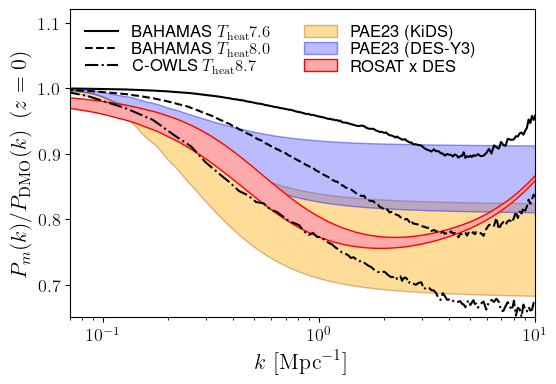

In [8]:
plt.figure(figsize=(6, 4))

for sim, ls in zip(["BAHAMAS-7.6",
                    "BAHAMAS-8.0",
                    "COSMO-OWLS"],
                   ["-", "--", "-."]):
    nm, k, r = parse_pkdat(pkdat[sim])
    plt.plot(k * cosmo["h"], r, ls, c="black", label=nm)
plt.fill_between(ks,
                 ratio_mean_KiDS[0] - ratio_std_KiDS[0],
                 ratio_mean_KiDS[0] + ratio_std_KiDS[0],
                 facecolor="#FFAA00", edgecolor="#AA5500", alpha=0.4,
                 label="PAE23 (KiDS)")
plt.fill_between(ks,
                 ratio_mean_DES[0] - ratio_std_DES[0],
                 ratio_mean_DES[0] + ratio_std_DES[0],
                 facecolor="#5555FF", edgecolor="b", alpha=0.4,
                 label="PAE23 (DES-Y3)")
plt.fill_between(ks,
                 ratio_mean_chains[0] - ratio_std_chains[0],
                 ratio_mean_chains[0] + ratio_std_chains[0],
                 facecolor="#FFAAAA", edgecolor="r",
                 label="ROSAT x DES")
plt.xscale("log")
plt.xlim([0.07, 10.0])
plt.ylim([0.65, 1.12])
plt.xlabel(r"$k\,\,[{\rm Mpc}^{-1}]$", fontsize=16)
plt.ylabel(r"$P_m(k)/P_{\rm DMO}(k)\,\,\,(z=0)$", fontsize=16)
plt.tick_params(axis="both", labelsize=13)

plt.legend(frameon=False,
           fontsize=12,
           ncol=2,
           labelspacing=0.1,
           loc="upper left")

plt.savefig("plots/baryon_boost.pdf", bbox_inches="tight")